![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import collections
import re
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/worldcities/worldcities.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')
df_population = pd.read_csv('/kaggle/input/worldcities/worldcities.csv') # дополнительный датасет с количеством насления в городах

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [13]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
40219,id_8514,Paris,NaN,8516.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187147-d12610491-Reviews-L...,d12610491,1,4.5
33362,id_1360,Zurich,['Italian'],1365.0,$$ - $$$,13.0,"[['Great coffee in the morning, and a wine ba....",/Restaurant_Review-g188113-d3584254-Reviews-Ca...,d3584254,1,3.5
42366,id_1413,Edinburgh,['British'],1414.0,NaN,6.0,"[['Nice staff', 'Friendly new cafe'], ['03/01/...",/Restaurant_Review-g186525-d10303614-Reviews-M...,d10303614,1,3.5
25418,id_4175,Paris,"['French', 'European']",4176.0,$$ - $$$,191.0,"[['Good Food and Friendly Service', 'very good...",/Restaurant_Review-g187147-d2571411-Reviews-Le...,d2571411,1,3.5
15378,id_3031,Lisbon,NaN,3034.0,NaN,24.0,"[['What a place!', 'An excellent place'], ['11...",/Restaurant_Review-g189158-d2646976-Reviews-O_...,d2646976,1,4.5


Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## Обработка признаков

In [14]:
data.isna().sum()

Restaurant_id            0
City                     0
Cuisine Style        11590
Ranking                  0
Price Range          17361
Number of Reviews     3200
Reviews                  2
URL_TA                   0
ID_TA                    0
sample                   0
Rating                   0
dtype: int64

In [15]:
# Для примера я возьму столбец Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

Для начала посмотрим какие признаки у нас могут быть категориальными.

In [16]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
dtype: int64

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

### Price Range

In [17]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  

In [18]:
# Ваша обработка 'Price Range'
data['Price Range'].fillna(data['Price Range'].mode()[0], inplace=True)
price_dict = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
data['Price Range'] = data['Price Range'].map(price_dict)
data['Price Range']

0        2
1        2
2        2
3        3
4        3
        ..
49995    2
49996    2
49997    2
49998    2
49999    2
Name: Price Range, Length: 50000, dtype: int64

In [19]:
data.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating',
       'Number_of_Reviews_isNAN'],
      dtype='object')

## ID_TA

In [20]:
# Просто преобразуем в int и посмотрим что, выдаст
data['ID_TA'] = data['ID_TA'].apply(lambda x: int(x[1:]))

## Reviews

In [21]:
# Вытащим из колонки 'Reviews' дату публикаций и создадим новый признак количество дней 
data['Reviews'][1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

In [22]:
# обработаем колонку Reviews преобразовав данные в список(data['Reviews'][0] - отзыв, data['Reviews'][1] - дата)
data['Reviews'] = data.Reviews.dropna().apply(lambda x: eval(x.replace('nan', '').replace('[,', "['',"))) 
data['date'] = data['Reviews'].dropna().apply(lambda x: x[1]) # берем из списка даты
data['date_1'] = data['date'].dropna().apply(lambda x: x[1] if len(x) == 2 else np.nan) # если в списке 2 даты берем вторую
data['date_2'] = data['date'].dropna().apply(lambda x: x[0] if len(x) > 0 else np.nan) # берем первую
data.drop('date', axis=1, inplace=True) # удалим колонку date 
# переведем в datetime
data['date_1'] = pd.to_datetime(data['date_1'])
data['date_2'] = pd.to_datetime(data['date_2'])


In [23]:
data['date_1'][1]

Timestamp('2017-10-29 00:00:00')

In [24]:
# Заполним пропщунные даты их средними значениями
data['date_1'].fillna(data['date_1'].mean(), inplace=True)
data['date_2'].fillna(data['date_2'].mean(), inplace=True)
# Создадим новый признак длителность отзывов между date_1 и date_2
data['days'] = abs(data['date_2'] - data['date_1']).dt.days


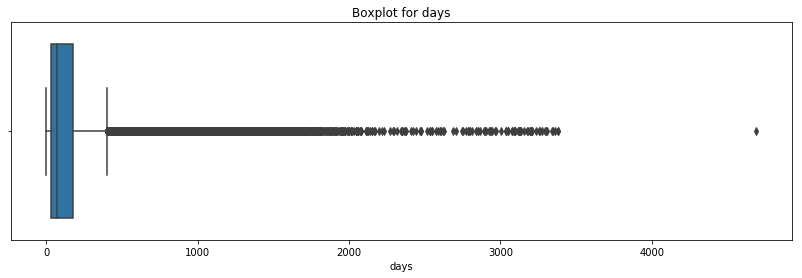

In [25]:
fig, ax = plt.subplots(figsize=(14, 4))
sns.boxplot(x='days',data=data,ax=ax)
plt.xticks(rotation=0)
ax.set_title('Boxplot for ' + 'days')
plt.show()

In [26]:
# Посчитаем сколько дней прошло с последнего отзыва до наст. времени
def days(day_1, day_2):
  dt_now = datetime.today()
  if not day_1 or not day_2:
    return 0
  if day_1 > day_2:
    return (dt_now - pd.to_datetime(day_1)).days
  return (dt_now - pd.to_datetime(day_2)).days

data['days_now'] = data[['date_1', 'date_2']].apply(lambda x: days(*x), axis=1)
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
data['Number of Reviews'].fillna(0, inplace=True)


## Cuisine Style

In [27]:
# Заменим пробелы на 'other' и удалим не нужные символы '"' в Cuisine Style
data['Cuisine Style'].fillna("['Other']", inplace=True)
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: eval(x))  # получили столбец со списками

# Соберем все рестораны в коллекцию. Она нам пригодится для создания новых признаков
c = collections.Counter()
for row in data['Cuisine Style']:
  for i in row:
    c[i] +=1
# Мы получили всего 125 кухонь - для создания новых признаков это слишком много. Отсеим наименее распространенные кухни.
kitches = dict(c)
kitches_by_350 = [i for i in kitches if kitches[i] > 350]

Создадим функцию для заполнения значения в каждой ячейке. Функция будет проверять наличие конкретной кухни в столбце 'Cuisine Style' для текущего ресторана и возвращать 1, если кухня есть в ресторане, и 0, если отсутствует. Организуем цикл с параметром, в котором будем перебирать наименования всех кухонь (kitches_by_350). Для каждой кухни создадим в датафрейме столбец с соответствующим названием и заполним его единичками и нулями, применив к датафрейму, а точнее, к столбцу 'Cuisine Style', функцию, созданную нами на предыдущем шаге. Код функции, с помощью которой мы будем создавать новые столбцы и заполнять их значениями, могут выглядеть следующим образом:

In [28]:
def find_item(cell):
    if item in cell:
        return 1
    return 0

for item in kitches_by_350:
    data[item] = data['Cuisine Style'].apply(find_item)

#Кухонь которых меньше 350 закинем в один столбец
kitches_rare = [i for i in kitches if kitches[i] <= 350]

def kitch_count(cell):
    # функция возвращает количество редких кухонь в каждом ресторане.
    x = 0
    for i in kitches_rare:
        if i in cell:
            x += 1
    return x

data['kitch_rare'] = data['Cuisine Style'].apply(kitch_count)

# Теперь мы можем заменить в 'Cuisine Style' название кухни на их количество. Таким образом мы создадим еще один признак.
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: len(x))

In [29]:
data

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,International,Gastropub,German,Contemporary,Diner,Grill,Mexican,Latin,Delicatessen,kitch_rare
0,id_0,Paris,2,12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,10746918,0,...,0,0,0,0,0,0,0,0,0,0
1,id_1,Helsinki,5,106.0,2,97.0,"[[Very good reviews!, Fine dining in Hakaniemi...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,6674944,0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,Edinburgh,1,810.0,2,28.0,"[[Better than the Links, Ivy Black], [12/28/20...",/Restaurant_Review-g186525-d13129638-Reviews-B...,13129638,0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,London,5,1669.0,3,202.0,"[[Most exquisite, Delicious and authentic], [1...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,680417,0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,Bratislava,6,37.0,3,162.0,"[[Always the best in bratislava, Very good but...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,1112354,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,4,500.0,2,79.0,"[[The real Italian experience!, Wonderful food...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,2104414,1,...,0,0,0,0,0,0,0,0,0,0
49996,id_6340,Paris,5,6341.0,2,542.0,"[[Parisian atmosphere, Bit pricey but interest...",/Restaurant_Review-g187147-d1800036-Reviews-La...,1800036,1,...,0,0,0,0,0,0,0,0,0,0
49997,id_1649,Stockholm,2,1652.0,2,4.0,"[[Good by swedish standards, A hidden jewel in...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,947615,1,...,0,0,0,0,0,0,0,0,0,0
49998,id_640,Warsaw,5,641.0,2,70.0,"[[Underground restaurant, Oldest Restaurant in...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,1100838,1,...,0,0,0,0,0,0,0,0,0,0


## population

In [30]:
# Используем доп данные из df_population - количество человек проживающих в городах.
# Переимнунуем правельное название города. По остальным все ок.
data.loc[data.City == 'Oporto', 'City'] = 'Porto'
city_lst = data.City.unique() # создадим список тех городов по которым нам нужно получить доп. данные.
# Отфильтруем данные от лишних стран.
df_population = df_population[(df_population.city.isin(city_lst)) &
                  (df_population.country != 'United States') &
                  (df_population.country != 'Canada') &
                  (df_population.country != 'Venezuela')]
# Проверяем все ли города у нас есть в доп. датафрейме
set(city_lst) - set(df_population.city) # 

{'Krakow', 'Zurich'}

In [31]:
# Переименуем в доп. дата фрейме колонку City
df_population.rename(columns={'city':'City'}, inplace=True)

# Выбераем нужные столбцы
df_population = df_population[['City','population']]

# Сливаем оба дата фрейма в один
data = data.merge(df_population, how = 'left', on = 'City')

# Заполним population где города Zurich, Krakow т.к. их не было в наших данных
data.loc[data.City == 'Krakow', 'population'] = 779115.0
data.loc[data.City == 'Zurich', 'population'] = 434008.0
data['population']  = round((data['population'] / 1000000), 2)
data[data.City == 'Zurich'].population

128      0.43
144      0.43
195      0.43
199      0.43
340      0.43
         ... 
49500    0.43
49546    0.43
49644    0.43
49825    0.43
49852    0.43
Name: population, Length: 685, dtype: float64

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

## Ranking

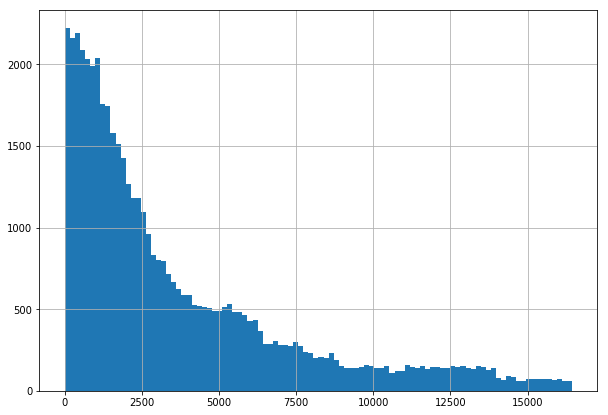

In [32]:
plt.rcParams['figure.figsize'] = (10,7)
data['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

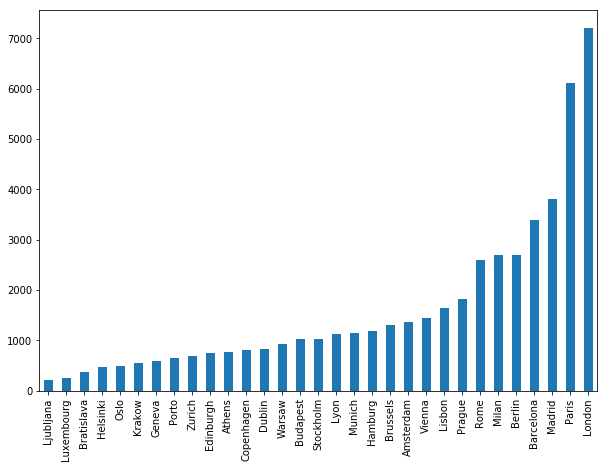

In [33]:
data['City'].value_counts(ascending=True).plot(kind='bar')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

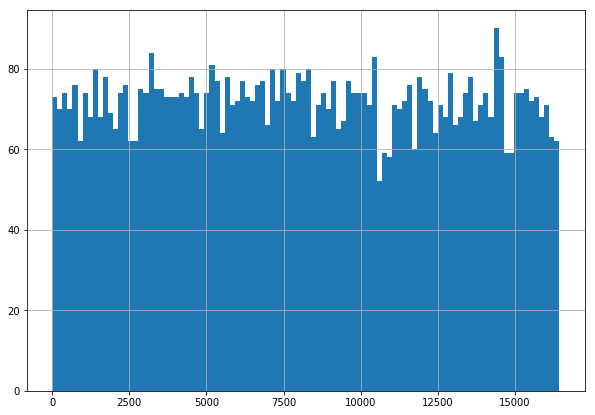

In [34]:
data['Ranking'][data['City'] =='London'].hist(bins=100)

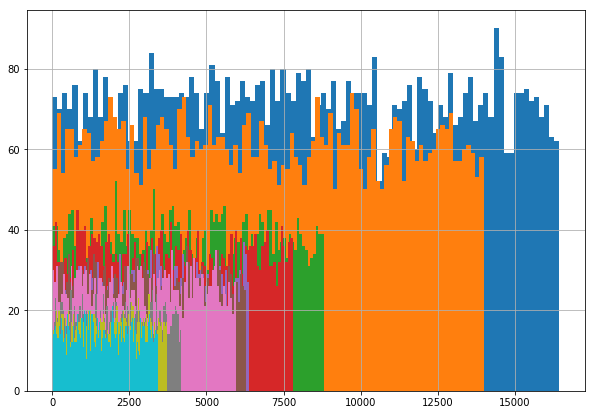

In [35]:
# посмотрим на топ 10 городов
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение. 


In [36]:
# Создадим новый признак количество ресторанов в городе
city_counts_dct = dict(data['City'].value_counts())
data['city_counts'] = data['City'].map(city_counts_dct)

Разделив Ranking — место, которое 
занимает данный ресторан среди всех ресторанов воего города  на количество ресторанов(city_counts), мы уберем смещение.

In [37]:
data['rank_city'] = data['Ranking'] / data['city_counts']

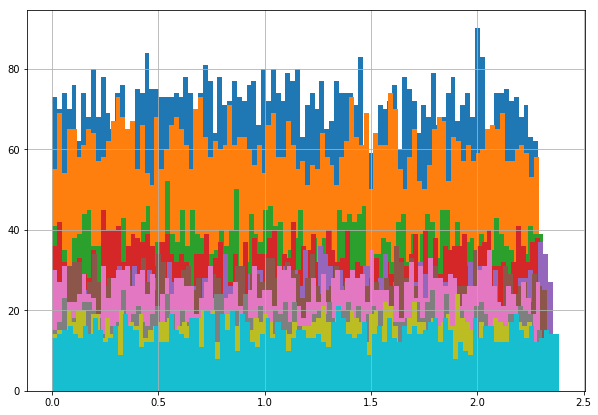

In [38]:
# Снова посмотрим на топ 10 городов
for x in (data['City'].value_counts())[0:10].index:
    data['rank_city'][data['City'] == x].hist(bins=100)
plt.show()

### Посмотрим распределение целевой переменной

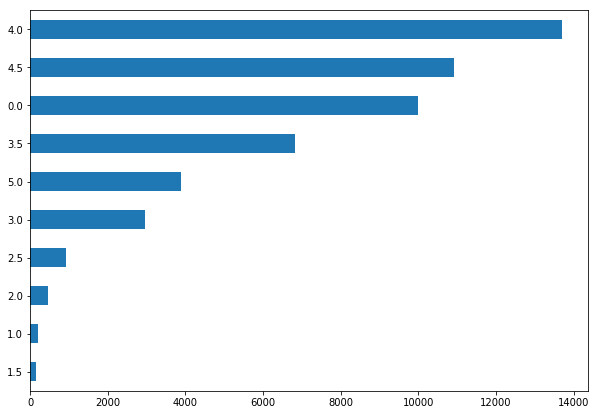

In [39]:
data['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

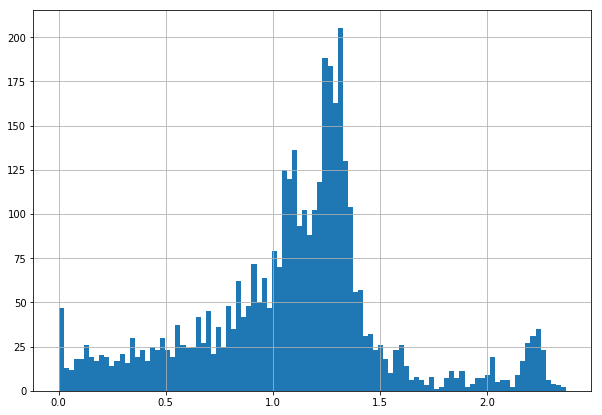

In [40]:
data['rank_city'][data['Rating'] == 5].hist(bins=100)

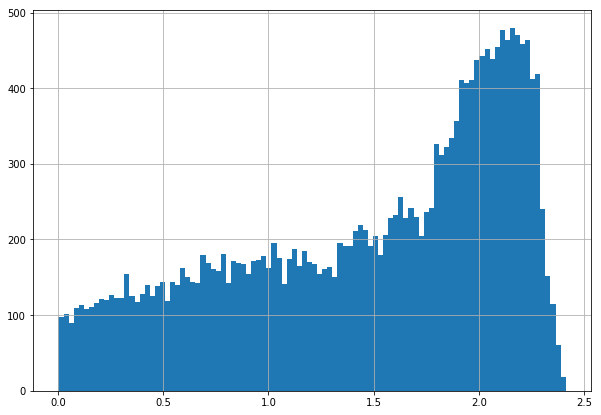

In [41]:
data['rank_city'][data['Rating'] < 4].hist(bins=100)

## Корреляция признаков

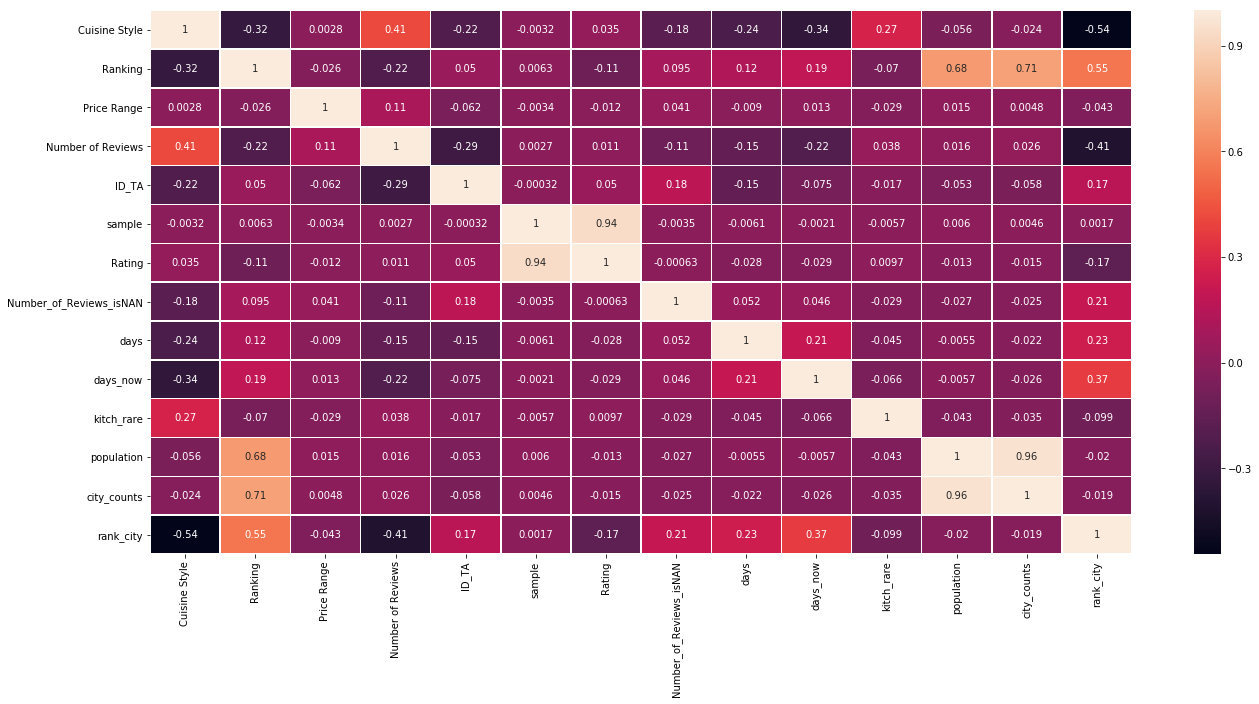

In [42]:
fig, ax = plt.subplots(figsize=(22, 10))
sns.heatmap(data.drop(kitches_by_350, axis=1).corr(), annot=True, linewidths=.5, ax=ax) # без основных видов кухонь и City_dummies

Удалим сильно корелирующие значения

In [43]:
# data.drop('city_counts', axis=1, inplace=True)

In [44]:
data = pd.get_dummies(data, columns=['City'], dummy_na=True) # То что хотели сделать выше. Создать новый признак.

In [45]:
# Выделем и удалим все не числовые значения из датафрейма
selected_dtype_obj = data.select_dtypes(include=['object', 'datetime64']).columns
selected_dtype_obj
data.drop(selected_dtype_obj, axis=1, inplace=True)
# data.drop('Ranking', axis=1, inplace=True)

## Data Preprocessing


#### Запускаем и проверяем что получилось

In [46]:
df_preproc = data
df_preproc.sample(10)

,Cuisine Style,Ranking,Price Range,Number of Reviews,ID_TA,sample,Rating,Number_of_Reviews_isNAN,days,days_now,...,City_Oslo,City_Paris,City_Porto,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
42097,2,1748.0,2,109.0,1136969,1,4.0,0,301,1234,...,0,0,0,0,0,0,0,0,0,0
35349,3,307.0,2,1298.0,3679830,1,4.5,0,860,1129,...,0,0,0,0,1,0,0,0,0,0
36726,1,4129.0,2,0.0,12827824,1,5.0,1,233,1201,...,0,0,0,0,0,0,0,0,0,0
46635,1,1919.0,2,15.0,9729591,1,3.5,0,176,1230,...,0,0,0,0,0,0,0,0,0,0
34057,5,88.0,2,1628.0,1099420,1,4.5,0,2,1118,...,0,0,0,0,0,0,0,0,0,0
19064,1,8637.0,2,0.0,9808238,1,4.0,1,373,1434,...,0,0,0,0,0,0,0,0,0,0
29549,4,5255.0,2,88.0,3751477,1,4.0,0,85,1296,...,0,1,0,0,0,0,0,0,0,0
41350,4,617.0,2,64.0,776474,1,4.0,0,137,1217,...,0,0,0,0,0,1,0,0,0,0
9191,2,2827.0,2,9.0,5444740,0,0.0,0,69,1365,...,0,0,0,0,0,0,0,0,0,0
4396,3,962.0,2,13.0,12652784,0,0.0,0,18,1129,...,0,0,0,0,0,0,0,0,0,0


In [47]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 101 entries, Cuisine Style to City_nan
dtypes: float64(5), int64(63), uint8(33)
memory usage: 27.9 MB


In [48]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [49]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [50]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 100), (40000, 100), (40000, 99), (32000, 99), (8000, 99))

# Model 
Сам ML

In [51]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [52]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [53]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [54]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.19998937499999997


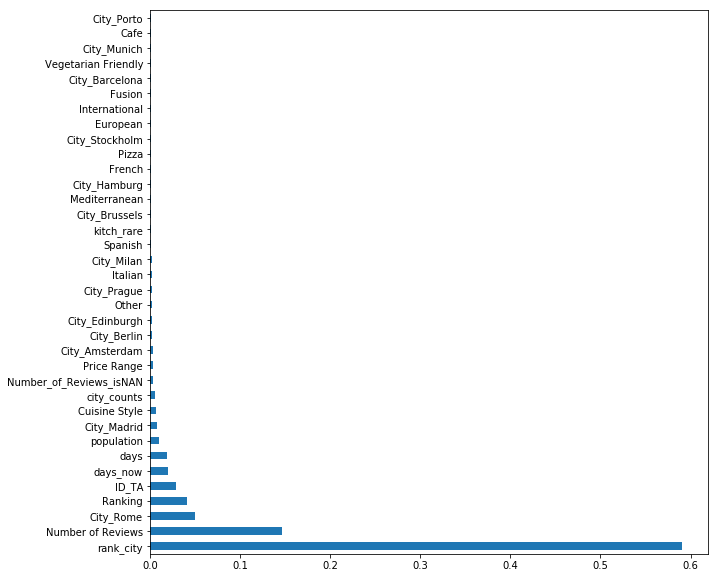

In [55]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(36).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [56]:
test_data.sample(10)

,Cuisine Style,Ranking,Price Range,Number of Reviews,ID_TA,Rating,Number_of_Reviews_isNAN,days,days_now,Bar,...,City_Oslo,City_Paris,City_Porto,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
8332,5,1621.0,2,234.0,737397,0.0,0,68,1178,1,...,0,0,0,0,0,0,0,0,0,0
4090,1,2815.0,2,5.0,8743345,0.0,0,109,1616,0,...,0,0,0,0,0,0,0,0,0,0
962,3,400.0,2,61.0,4259209,0.0,0,40,1295,0,...,1,0,0,0,0,0,0,0,0,0
1175,1,722.0,2,8.0,10901200,0.0,0,137,1191,0,...,0,0,0,0,0,0,0,0,0,0
1518,2,1707.0,2,45.0,2442997,0.0,0,53,1207,0,...,0,0,0,0,0,0,0,0,0,0
4009,1,7692.0,2,150.0,3506075,0.0,0,5,1116,0,...,0,0,0,0,0,0,0,0,0,0
6040,6,1627.0,2,422.0,3891496,0.0,0,0,1121,1,...,0,0,0,1,0,0,0,0,0,0
5153,5,496.0,2,312.0,2190969,0.0,0,3,1172,0,...,0,0,0,0,0,0,0,0,0,0
4462,5,351.0,2,334.0,2475194,0.0,0,86,1125,0,...,0,0,0,0,0,0,0,0,0,0
5072,1,885.0,2,218.0,7160431,0.0,0,195,1485,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
test_data = test_data.drop(['Rating'], axis=1)

In [58]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [59]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [60]:
predict_submission

array([3.02 , 4.23 , 4.24 , ..., 3.075, 4.495, 4.185])

In [61]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.02
1,id_1,4.23
2,id_2,4.24
3,id_3,4.32
4,id_4,4.42
5,id_5,4.41
6,id_6,2.30
7,id_7,2.26
8,id_8,4.06
9,id_9,4.59


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
